In [2]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from betavae import BetaVAE, compile_vae, extract_latent_dimensions, weights
from optimize_utils import get_optimizer

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [3]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [4]:
# Load the best hyperparameters
study_name = "BetaVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [5]:
#Initialize the model and optimizer
model = BetaVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 192.4067674323694, Val Loss: 495.59296332465277, Test Loss: 489.45863172743054
Epoch 2, Train Loss: 166.34088298740673, Val Loss: 568.6980794270834, Test Loss: 744.1025933159722
Epoch 3, Train Loss: 151.22412983908583, Val Loss: 175.78262668185764, Test Loss: 190.81260850694446
Epoch 4, Train Loss: 143.7757025419776, Val Loss: 349.6133626302083, Test Loss: 350.45716688368054
Epoch 5, Train Loss: 137.19845936333957, Val Loss: 149.1055162217882, Test Loss: 161.01553005642361
Epoch 6, Train Loss: 126.38743003731344, Val Loss: 112.64457194010417, Test Loss: 115.66418117947049
Epoch 7, Train Loss: 123.41488820545709, Val Loss: 103.18151516384549, Test Loss: 108.35276624891493
Epoch 8, Train Loss: 117.64538902168843, Val Loss: 104.94844224717882, Test Loss: 105.84016248914931
Epoch 9, Train Loss: 113.9135931669776, Val Loss: 101.86839463975694, Test Loss: 109.68589613172743
Epoch 10, Train Loss: 109.73868353544776, Val Loss: 100.33981323242188, Test Loss: 101.39214409722

In [6]:
# Save the model
model_path = pathlib.Path("results/best_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [7]:
# Save training history
history = {
    'loss' : train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

history_path = pathlib.Path("results/training_history_layers.json")
with open(history_path, 'w') as f:
    json.dump(history, f)

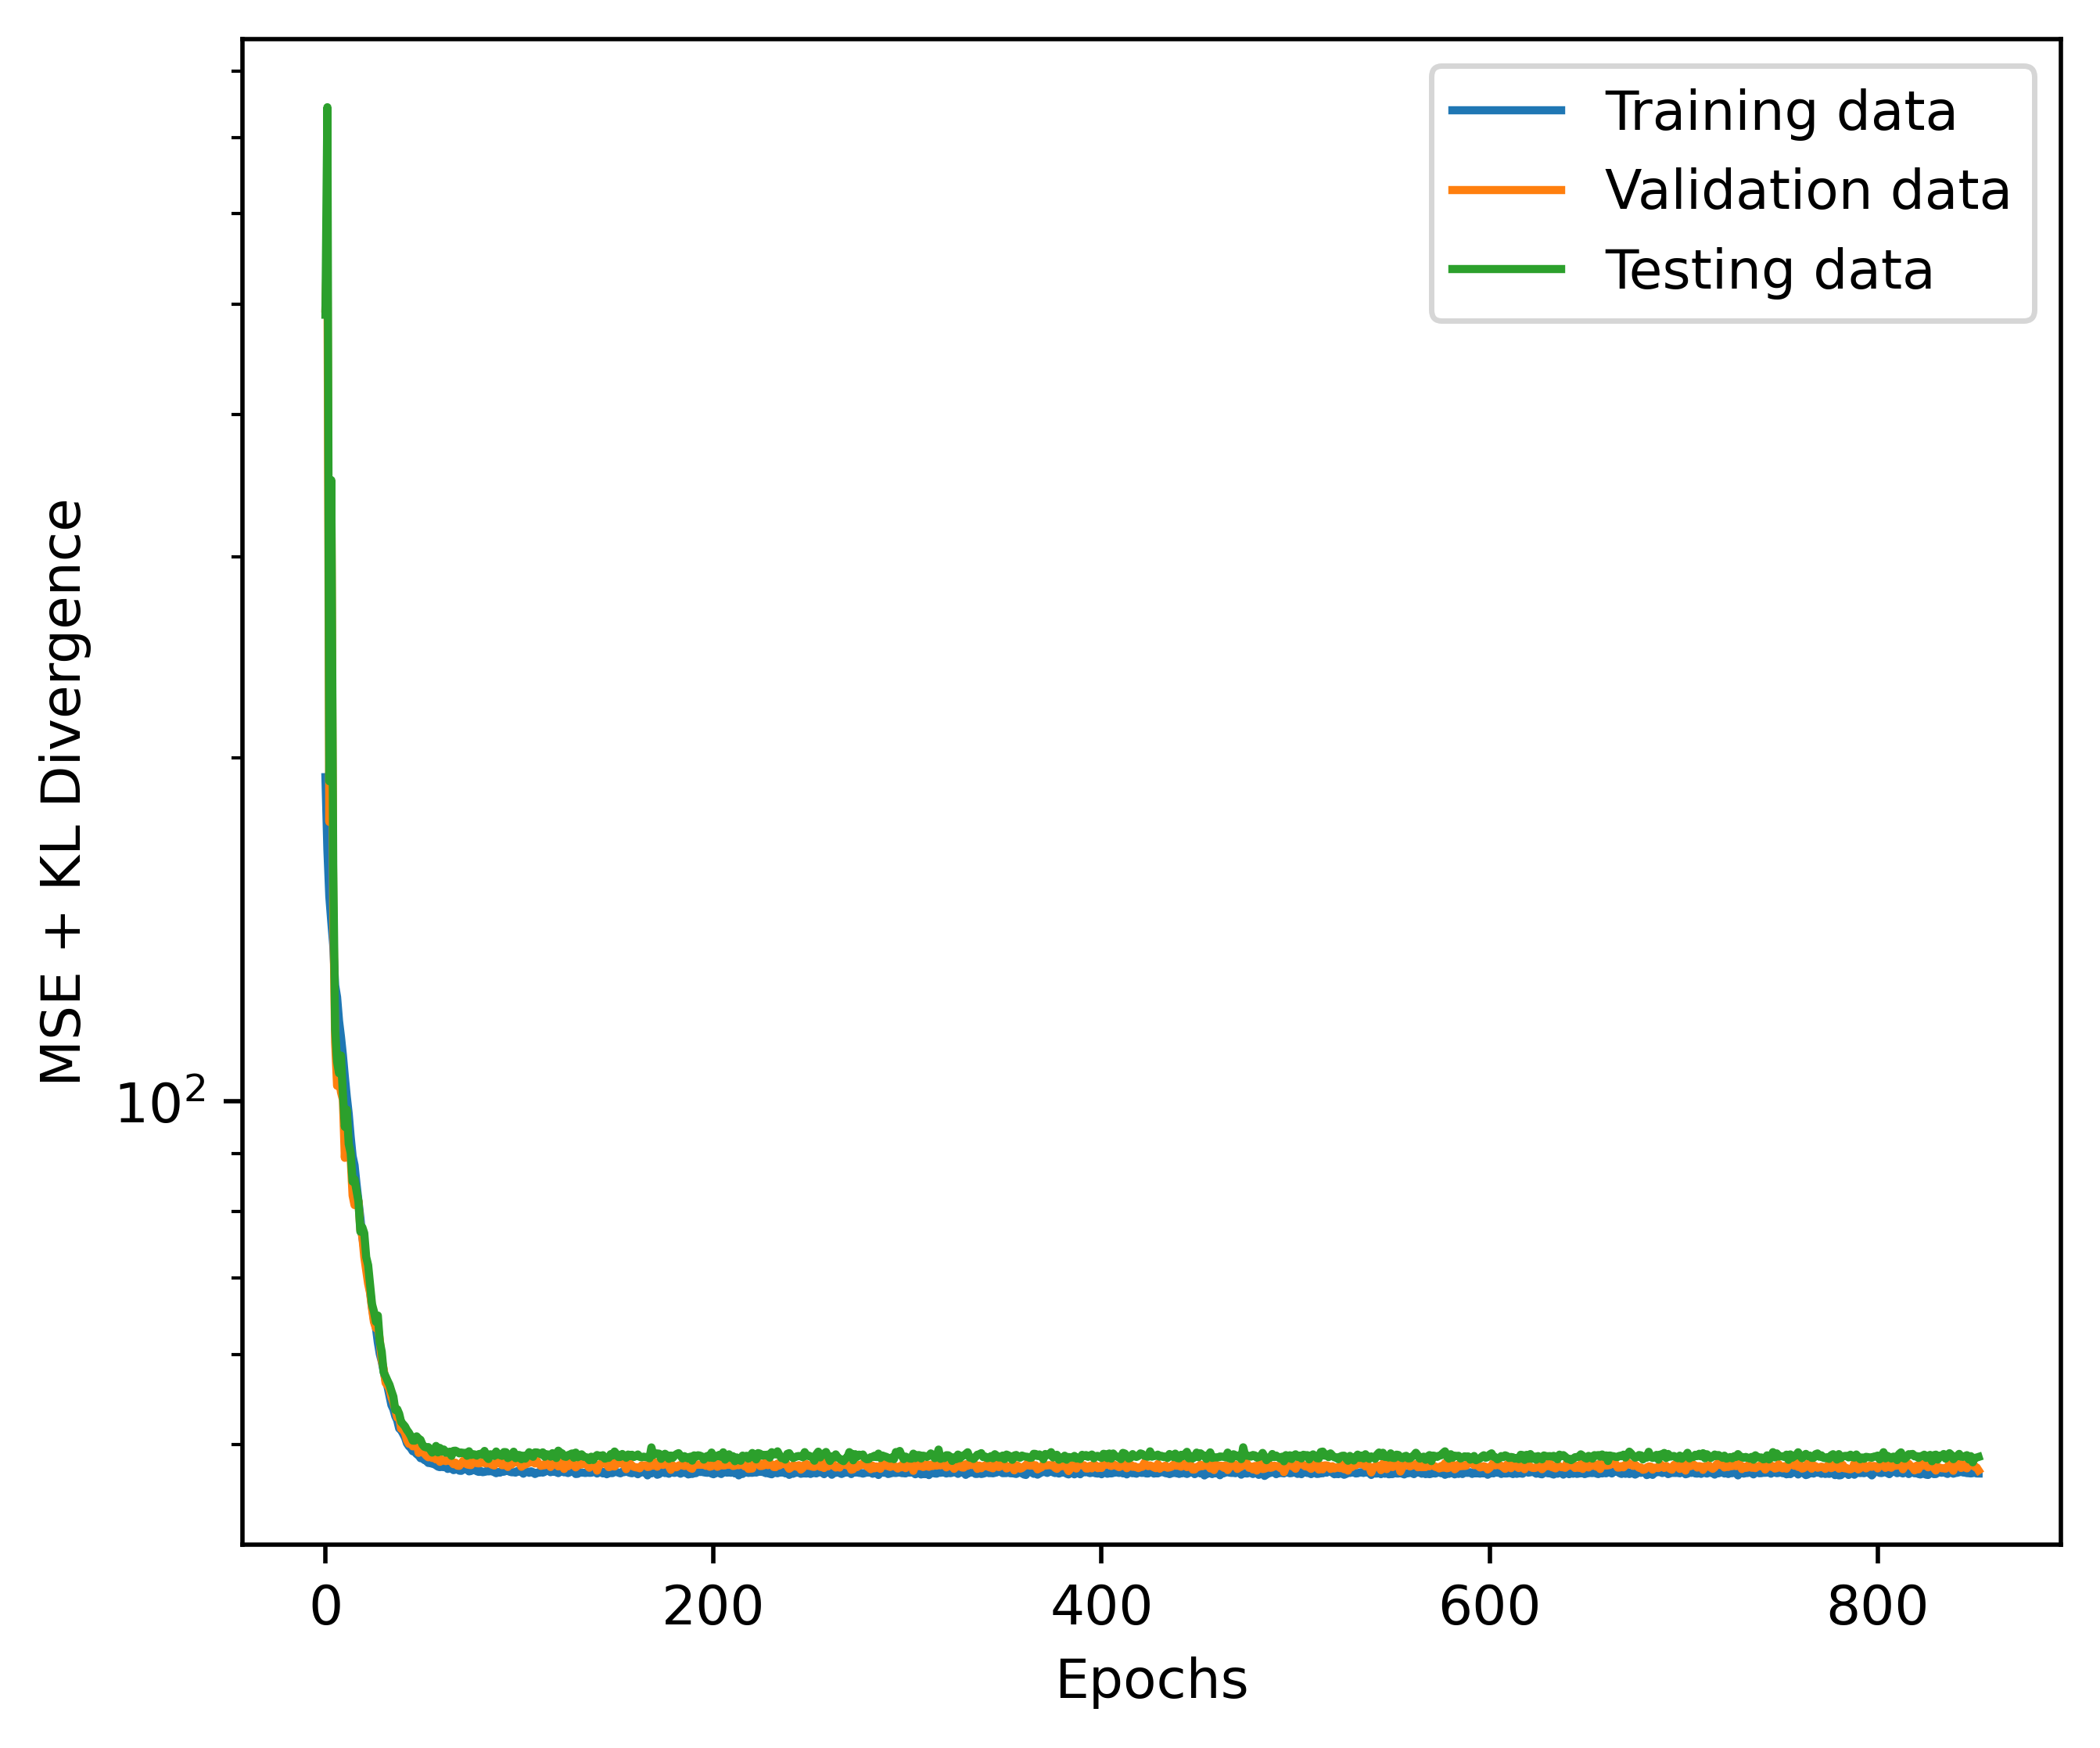

In [8]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(train_loss_history, label="Training data")
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

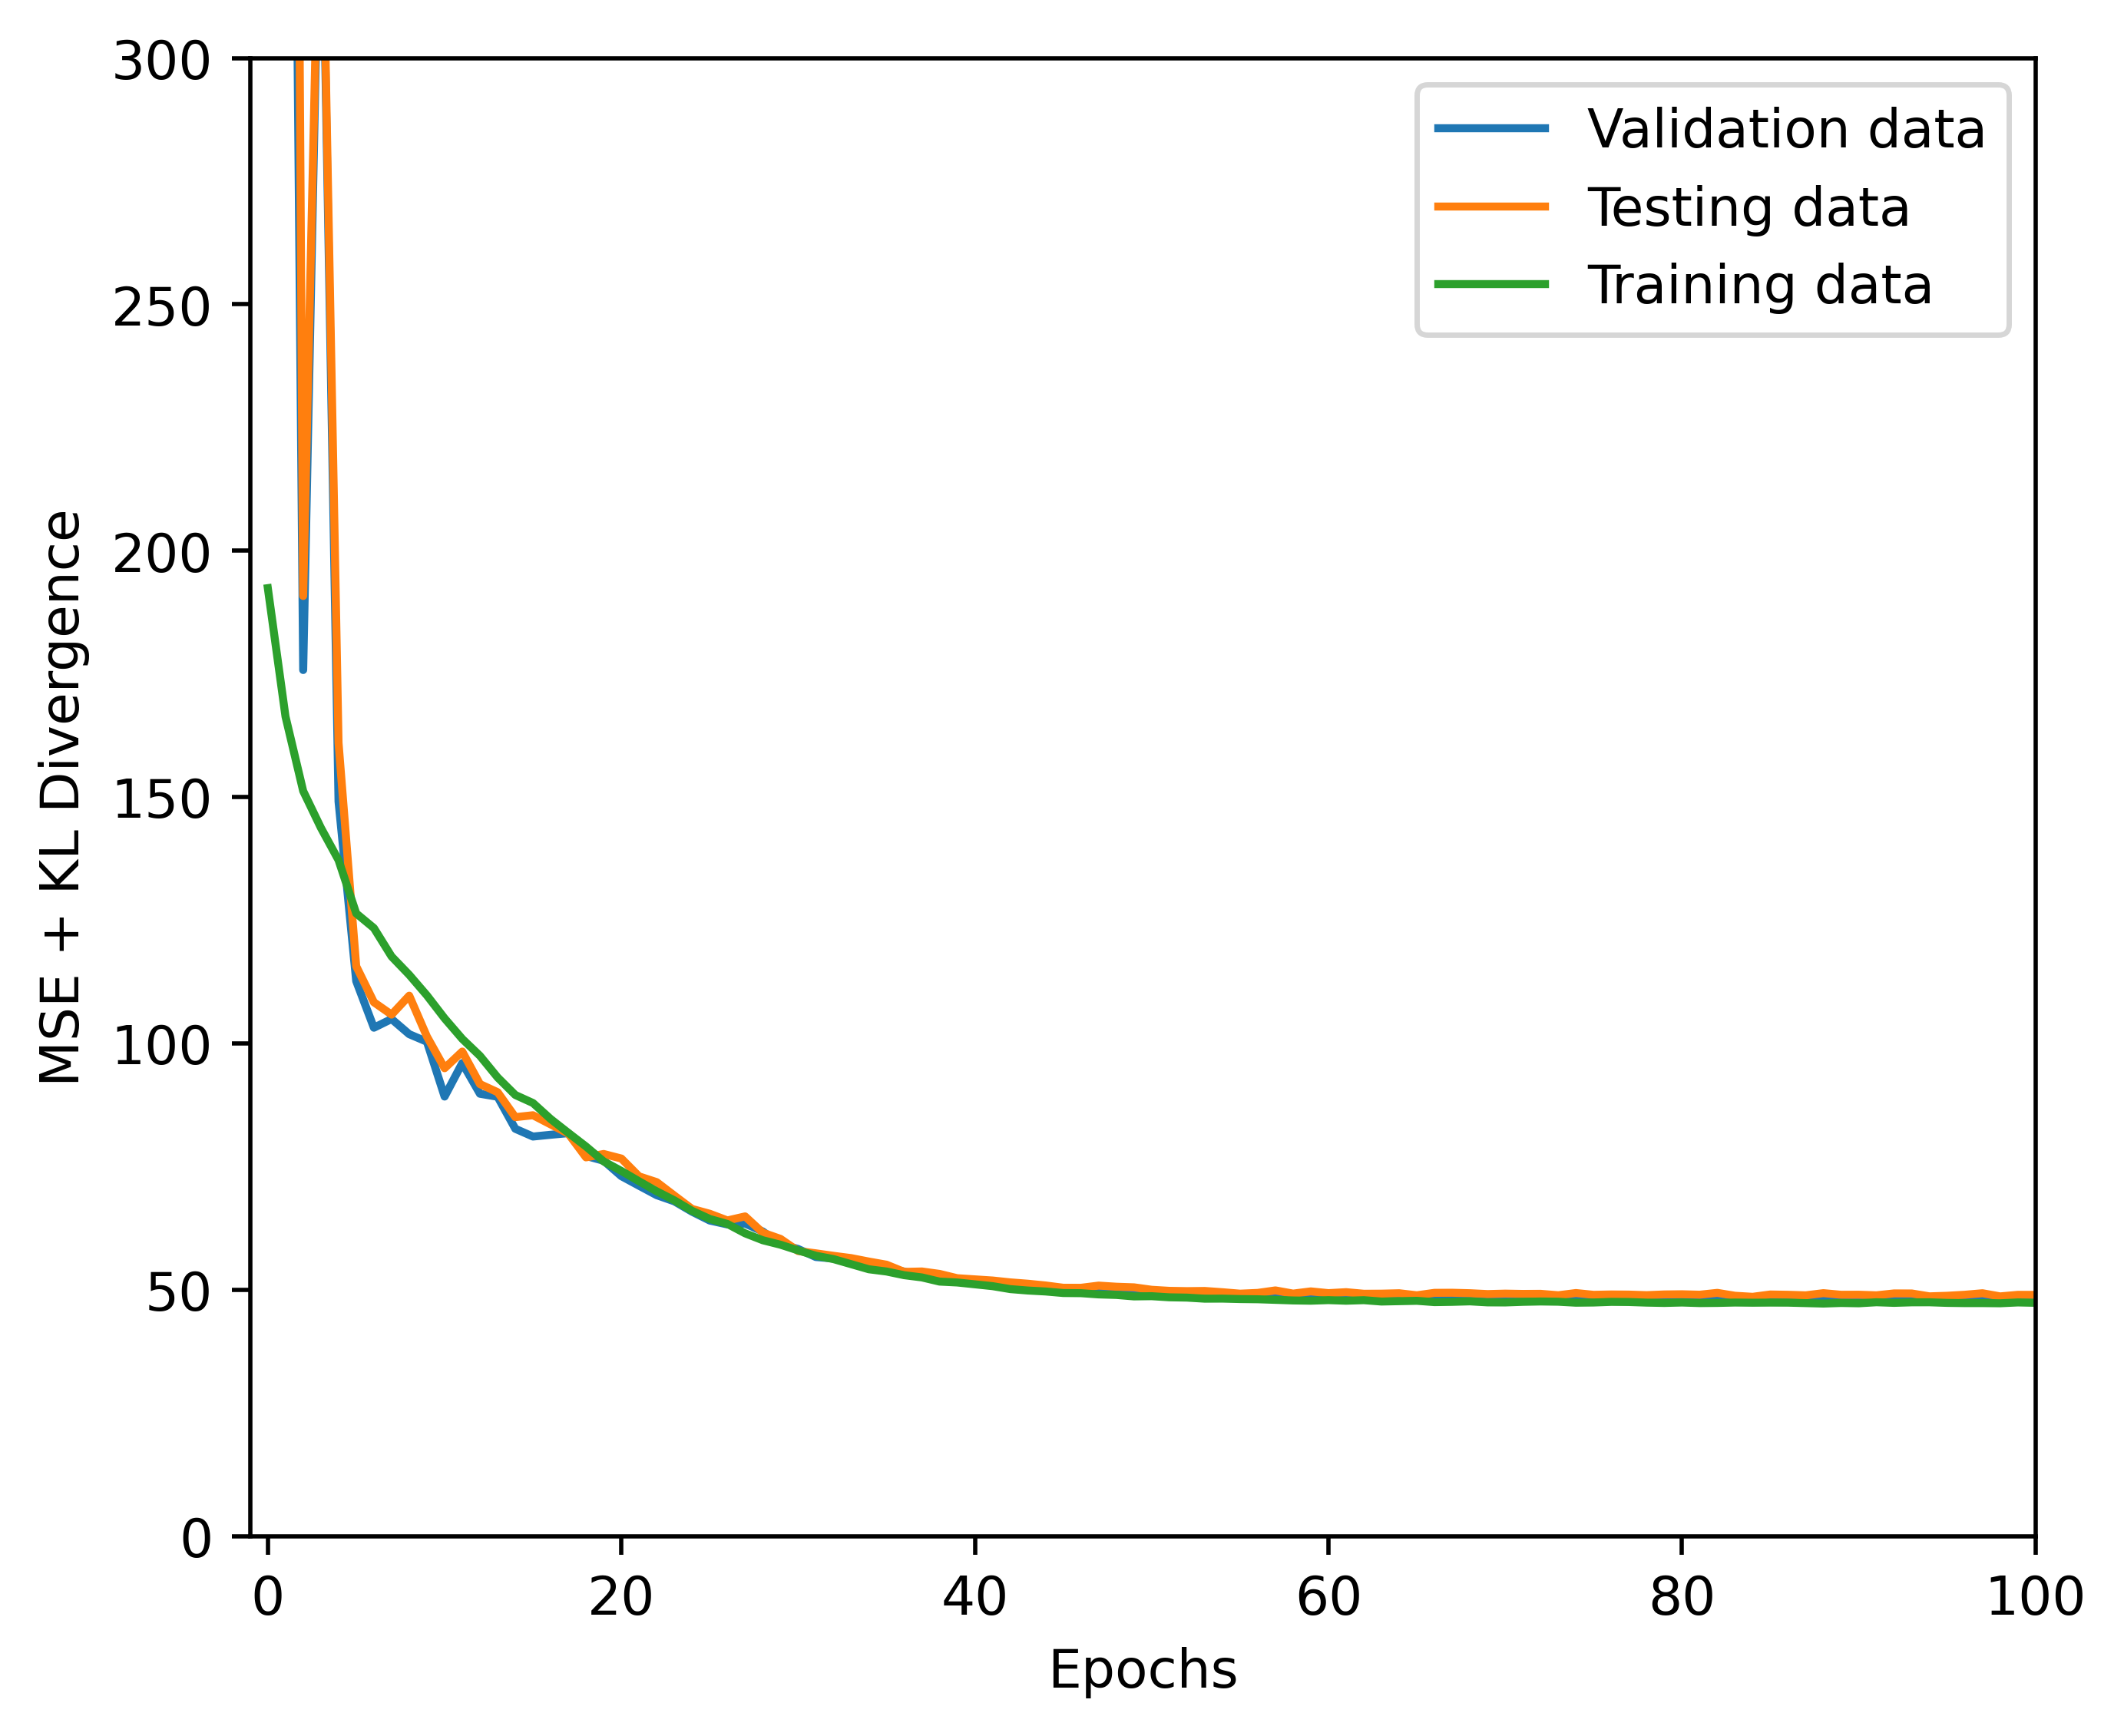

In [9]:
save_path = pathlib.Path("../1.data-exploration/figures/training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,100)
plt.ylim(0,300)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [10]:
# Extract the latent space dimensions
metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.parquet")
metadata = pd.read_parquet(metadata_df_dir)

train_and_test_subbed_dir = pathlib.Path("../0.data-download/data/train_and_test_subbed.parquet")
train_and_test_subbed = pd.read_parquet(train_and_test_subbed_dir)


# Convert DataFrame to NumPy and then Tensor
train_test_array = train_and_test_subbed.to_numpy()
train_test_tensor = torch.tensor(train_test_array, dtype=torch.float32)

#Create TensorDataset and DataLoader
tensor_dataset = TensorDataset(train_test_tensor)
train_and_test_subbed_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

path = "./results/latent_df.parquet"

latent_df = extract_latent_dimensions(model, train_and_test_subbed_loader, metadata, path)
print(latent_df.head())

      ModelID    0    1         2         3         4    5    6         7  \
0  ACH-000361  0.0  0.0  6.652991  4.557695  0.000000  0.0  0.0  0.226119   
1  ACH-000976  0.0  0.0  5.127921  3.768146  0.000000  0.0  0.0  0.935231   
2  ACH-000279  0.0  0.0  8.898233  6.099633  0.491055  0.0  0.0  1.773125   
3  ACH-000515  0.0  0.0  7.158413  4.744535  0.701644  0.0  0.0  2.367997   
4  ACH-001523  0.0  0.0  8.427553  4.999869  0.000000  0.0  0.0  0.104837   

          8    9        10  
0  2.039528  0.0  0.604451  
1  2.395282  0.0  0.291547  
2  3.135689  0.0  1.568407  
3  3.147441  0.0  1.060958  
4  2.192241  0.0  0.632491  


In [11]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train"
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
path = "./results/weight_matrix_gsea.parquet"
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = weights(model, train_data, path)